Блок кода для визуализации процесса обучения модели:


In [17]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

class ProgressPlotter:
  def __init__(self,title = None) -> None:
    self._history_dict = defaultdict(list)
    self.title = title

  def add_scalar(self, tag: str, value)-> None:
    self._history_dict[tag].append(value)

  def display_keys(self,ax,tags):
    if isinstance(tags, str):
      tags = [tags]
    history_len = 0
    ax.grid()
    for key in tags:
      ax.plot(self._history_dict[key], marker="X",label=key)
      history_len = max(history_len,len(self.history_dict[key]))
    if len(tags) > 1:
      ax.legend(loc="lower left")
    else:
      ax.set_ylabel(key)
    ax.set_xlabel('step')
    ax.set_xticks(np.arange(history_len))
    ax.set_xticklabels(np.arange(history_len))

  """
     groups list of keys like [['loss_train','loss_val'],['accuracy']]
     All charts within a group will be plot in the same axis
  """
  def display(self,groups = None):
    clear_output()
    if groups is None:
      groups = self._history_dict.keys()
    n_groups = len(groups)
    fig, ax = plt.subplots(n_groups, 1, figsize=(12, 3*n_groups))
    fig.suptitle(self.title)
    if n_groups == 1:
      ax = [ax]
    for i, keys in enumerate(groups):
      self.display_keys(ax[i],keys)
    fig.tight_layout()
    plt.show()

  @property
  def history_dict(self):
    return dict(self._history_dict)

In [18]:
import random
import torch

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

Блок обучения

In [15]:
@torch.inference_mode()
def get_correct_count(pred,labels):
  _, predicted = torch.max(pred.data, 1)
  return (predicted == labels).sum().item()

@torch.inference_mode()
def calaculate_accuracy(model, data_loader, criterion ):
    correct, total = 0, 0
    loss = 0
    for batch in data_loader:
        imgs, labels = batch
        pred = model(imgs.to(device))
        loss += criterion(pred.to(device), labels.to(device))
        correct += get_correct_count(pred.to(device),labels.to(device))
        total += labels.to(device).size(0)

    return correct / total , loss.item() / len(data_loader)

In [14]:
from tqdm import tqdm
import torch.nn as nn
import torch

def train(device, model, criterion, optimizer, num_epochs=10):
    pp = ProgressPlotter()
    for epoch in range(num_epochs):
        correct, total, ep_loss = 0, 0, 0
        for imgs, labels in train_loader:
            optimizer.zero_grad()
            images = imgs.to(device)
            lab = labels.to(device)
            outputs = model(images)
            out = outputs.to(device)
            loss = criterion(out, lab)
            correct += get_correct_count(out,lab)
            loss.backward()
            optimizer.step()
            total += lab.size(0)
            ep_loss += loss.item()
        # Logging
        pp.add_scalar('loss_train', ep_loss / len(train_loader))
        pp.add_scalar('accuracy_train', correct/total)

        accuracy, loss_val = calaculate_accuracy(model,val_loader,criterion)
        pp.add_scalar('loss_val',loss_val)
        pp.add_scalar('accuracy_val',accuracy)

        pp.display([['loss_train','loss_val'],['accuracy_train','accuracy_val']])
    return pp

# Задание 1. Функция свертки

Реализуйте функцию свёртки `conv(x, kernel, pad)`, где:


* $\text{x}$: Двумерный массив размером $(H, W)$;
* $\text{kernel}$: ядро свёртки размером $(K_h, K_w)$;

* $\text{pad}$: ширина дополнения с каждой из сторон массива. $\text{pad} \geq 0$.

Шаг ядра свёртки полагается равным единице

Результатом работы функции будет массив $out$ содержащий результат свертки входных данных с $kernel$ имеющий размер $(H', W')$:
  - $H' = 1 + (H + 2 \cdot pad - K_h)\ $.
  - $W' = 1 + (W + 2 \cdot pad - K_w)\ $;


In [ ]:
import numpy as np

def conv(x, kernel, pad):
    H, W = x.shape
    K_h, K_w = kernel.shape
    H_out = 1 + (H + 2 * pad - K_h)
    W_out = 1 + (W + 2 * pad - K_w)
    pad_x = np.pad(x, ((pad, pad), (pad, pad)), mode='constant')
    out = np.zeros((H_out, W_out))
    for i in range(H_out):
        for j in range(W_out):
            region = pad_x[i:i + K_h, j:j + K_w]
            out[i, j] = np.sum(region * kernel)
    return out

Тест

In [ ]:
M = np.array([[0, 0, 1, 0, 0],
              [0, 0, 1, 0, 0],
              [0, 0, 1, 0, 0],
              [0, 0, 1, 0, 0],
              [0, 0, 1, 0, 0]])

kernel = np.array([[1, 0, -1]])
actual = conv(M, kernel, pad=1)

print(actual.shape, "\n", actual)

expected = np.array([[0,  0,  0,  0,  0],
                     [0, -1,  0,  1,  0],
                     [0, -1,  0,  1,  0],
                     [0, -1,  0,  1,  0],
                     [0, -1,  0,  1,  0],
                     [0, -1,  0,  1,  0],
                     [0,  0,  0,  0,  0]])


assert np.array_equal(expected, actual), "Error"

(7, 5) 
 [[ 0.  0.  0.  0.  0.]
 [ 0. -1.  0.  1.  0.]
 [ 0. -1.  0.  1.  0.]
 [ 0. -1.  0.  1.  0.]
 [ 0. -1.  0.  1.  0.]
 [ 0. -1.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.]]


Воспользуйтесь созданной функцией `conv` для применения [оператора Собеля](https://ru.wikipedia.org/wiki/%D0%9E%D0%BF%D0%B5%D1%80%D0%B0%D1%82%D0%BE%D1%80_%D0%A1%D0%BE%D0%B1%D0%B5%D0%BB%D1%8F) к изображению.  

Выведите на экран:
* изначальное изображение
* приближённые производные по вертикали
* приближённые производные по горизонтали
* норму градиента (корень от суммы квадратов производных).

In [ ]:
import matplotlib.pyplot as plt
from skimage import data

camera = data.camera()

sobel_y = np.array([[ 1.0,  2.0, 1.0 ],
                        [ 0.0,  0.0, 0.0 ],
                        [-1.0, -2.0, -1.0]])
sobel_x = np.array([[ -1.0,  0.0, 1.0 ],
                        [ -2.0,  0.0, 2.0 ],
                        [ -1.0,  0.0, 1.0]])
mas_x = conv(camera * 255, sobel_y, 1)
mas_y = conv(camera * 255, sobel_x, 1)

H, W = camera.shape
grad = []
for i in range(H):
  grad.append([])
  for j in range(W):
    grad[i].append(np.sqrt(mas_x[i,j]**2 + mas_y[i,j]**2))

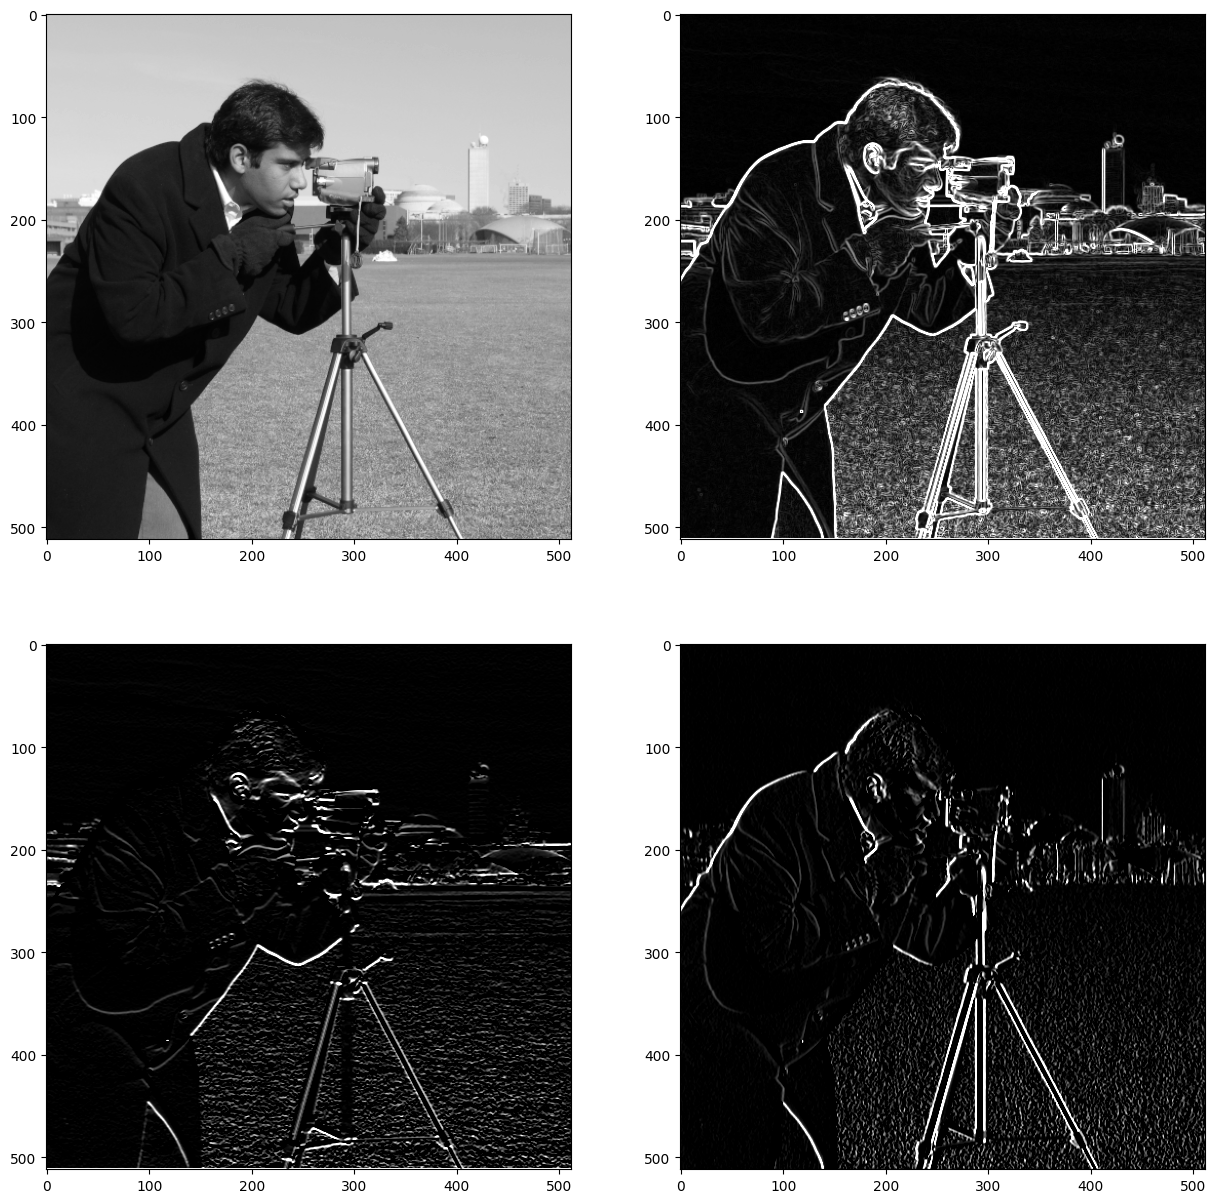

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs[0, 0].imshow(camera, cmap='gray', vmin=0, vmax=255)
axs[0, 1].imshow(grad, cmap='gray', vmin=0, vmax=255)
axs[1, 0].imshow(mas_x, cmap='gray', vmin=0, vmax=255)
axs[1, 1].imshow(mas_y, cmap='gray', vmin=0, vmax=255)

## Формат результата

Результатом является 4 изображения, пример:
<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX06/sobel_results.png"  width="1000">


# Задание 2. Создание сверточной сети для MNIST

Создайте сверточную сеть на Pytorch и обучите ее на MNIST.  
* Используйте не более трёх [сверточных](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) и не более двух [полносвязанных](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) слоев, а также один слой [пулинга](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) (слой пулинга и аргумент stride у сверточных слоев помогут избежать большой размерности на входе в линейный слой).
* Функцию активации выберите на свое усмотрение.  
* Не применяйте слои других типов.  
*  Рекомендуется использовать код для обучения **из лекции №5** и класс ProgressPlotter для вывода графиков

Функция для подсчета точности.
Изменять код в данном блоке не требуется.

In [13]:
import torch

def get_correct_count(pred, labels):
  _, predicted = torch.max(pred.data, 1)
  return (predicted.cpu() == labels.cpu()).sum().item()

@torch.inference_mode() # this annotation disable grad computation
def validate(model, data_loader, criterion, device = "cpu"):
    correct, total  = 0, 0
    loss = 0
    for imgs, labels in data_loader:
        pred = model(imgs.to(device))
        pred = pred.to(device)
        labels = labels.to(device)
        loss += criterion(pred, labels)
        total += labels.size(0)
        correct += get_correct_count(pred, labels)
    return correct / total,  loss.item() / len(data_loader)

In [12]:
import torch.nn as nn
import torch

class TwoLayerCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        scores = self.fc2(x)
        return scores

Загрузите MNIST:

https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from IPython.display import clear_output
from torch.utils.data import random_split
from torch.utils.data import DataLoader

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [ ]:
trainset, valset, _ = random_split(train_dataset, [12000, 3000, 45000])

train_loader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=256, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)
print(len(train_loader.dataset))
print(len(val_loader.dataset))
print(len(test_loader.dataset))

12000
3000
10000


Разместите код для обучения в этом блоке.

* Используйте GPU. Для этого Вам необходимо в верхней панели выбрать `Среда выполнения > Сменить среду выполнения` и заменить None на GPU.
* Для оценки точности используйте функцию `validate`

* Подумайте над тем, чтобы поместить код для обучения в функцию или класс, который вы сможете использовать в следующих заданиях.


In [11]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cuda


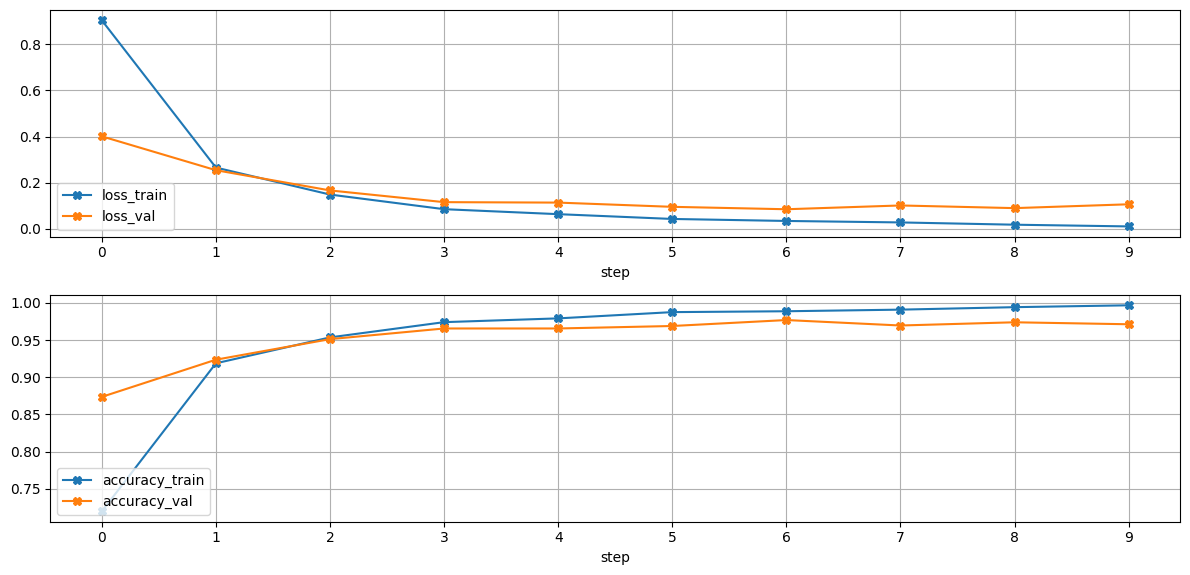

In [ ]:
model = TwoLayerCNN()
model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
pp = train(device, model, criterion, optimizer, num_epochs=10)

In [ ]:
test_accuracy, _ = calaculate_accuracy(model.eval(), test_loader, criterion)
print(f"Accuracy on TEST {test_accuracy:.2f}")

Accuracy on TEST 0.98


## Формат результата

Результатом является сверточная сеть обученная на MNIST, с точностью не ниже 0.9

# Задание 3. Построение графика

Постройте график зависимости точности вашей модели от количества свёрточных слоёв в ней: постройте модели, в которых будет 2, 3, 5, 7 слоев.   

Рекомендуется периодически уменьшать пространственные размеры карты признаков и одновременно удваивать количество каналов на выходе сверточного слоя. Для уменьшения пространственных размеров карт признаков рекомендуется использовать слой [пулинга](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html).  Для экономии времени в первом сверточном слое ограничьтесь 8-ю каналами на выходе.


График строится на основе точности модели после шести эпох обучения.

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
Accuracy with 2 conv layers: 0.95
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
Accuracy with 3 conv layers: 0.97
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
Accuracy with 5 conv layers: 0.98
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
Accuracy with 7 conv layers: 0.98
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
Accuracy with 9 conv layers: 0.94


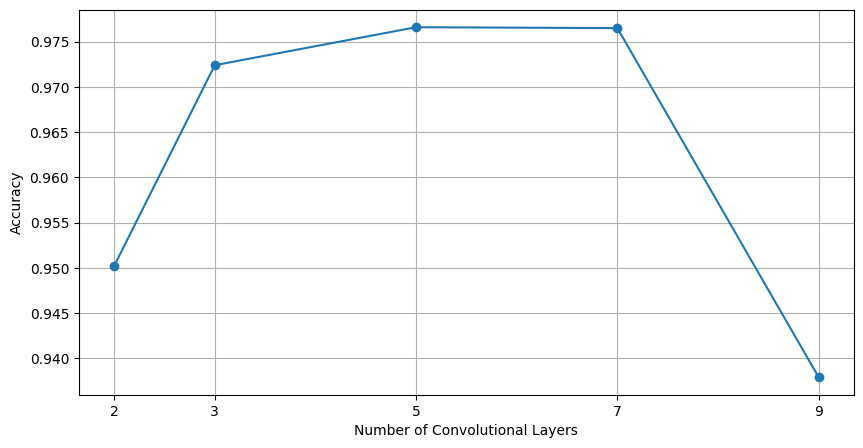

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, num_conv):
        super().__init__()
        layers = []
        in_channels = 1

        for i in range(num_conv):
            layers.append(nn.Conv2d(in_channels, 8 * (2 ** i), kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            in_channels = 8 * (2 ** i)

        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        layers.append(nn.Flatten())
        layers.append(nn.Linear(in_channels * 14 * 14, 128))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(128, 10))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

def train_model(num_conv_layers):
    model = ConvNet(num_conv_layers).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(6):
        print('epoch: ', epoch)
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    test_accuracy, _ = calaculate_accuracy(model.eval(), test_loader, criterion)
    return test_accuracy

conv_layers = [2, 3, 5, 7, 9]
accuracies = []

for num_layers in conv_layers:
    accuracy = train_model(num_layers)
    accuracies.append(accuracy)
    print(f'Accuracy with {num_layers} conv layers: {accuracy:.2f}')

plt.figure(figsize=(10, 5))
plt.plot(conv_layers, accuracies, marker='o')
plt.xlabel('Number of Convolutional Layers')
plt.ylabel('Accuracy')
plt.xticks(conv_layers)
plt.grid()
plt.show()


###Вывод:  
Рост точности: Сначала при увеличении слоев точность возрастает. Это может означать, что добавление слоев позволяет модели лучше извлекать особенности из данных и, соответственно, улучшать качество классификации.

Плато или снижение точности: При добавлении 7 сверток точность остается на уровне 0.98 - это может означать, что был достигнут предел в производительности модели.

Снижение точности при 9 слоях: Снижение точности до 0.94 может быть признаком переобучения.

## Формат результата

Результатом является график, пример:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX06/accuracy_epochs.png"  width="600">


# Задание 4. Сверточная сеть для классификации заболеваний растений

Используя созданные датасеты, обучите свёрточную нейронную сеть для определения заболевания растения. Используя фиксированную (по свёрточным слоям) архитектуру модели, посмотрите на качество обучения при различных размерах входных изображений и опишите причину наблюдаемой закономерности.

Создание датасета из набора файлов

Фотографии листьев растений находятся в трех архивах. Загрузим их:

In [1]:
!wget https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/ibeans/train.zip
!wget https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/ibeans/validation.zip
!wget https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/ibeans/test.zip

--2024-09-28 08:16:24--  https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/ibeans/train.zip
Resolving edunet.kea.su (edunet.kea.su)... 185.30.98.120
Connecting to edunet.kea.su (edunet.kea.su)|185.30.98.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143812152 (137M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 137.15M  7.49MB/s    in 25s     

2024-09-28 08:16:51 (5.40 MB/s) - ‘train.zip’ saved [143812152/143812152]

--2024-09-28 08:16:51--  https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/ibeans/validation.zip
Resolving edunet.kea.su (edunet.kea.su)... 185.30.98.120
Connecting to edunet.kea.su (edunet.kea.su)|185.30.98.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18504213 (18M) [application/zip]
Saving to: ‘validation.zip’

validation.zip      100%[===================>]  17.65M  4.07MB/s    in 4.3s    

2024-09-28 08:16:57 (4.07 MB/s) - ‘validation.zip’ save

и разархивируем

In [2]:
!unzip train.zip
!unzip validation.zip
!unzip test.zip

Archive:  train.zip
   creating: train/
   creating: train/healthy/
   creating: train/angular_leaf_spot/
   creating: train/bean_rust/
  inflating: train/healthy/healthy_train.265.jpg  
  inflating: train/healthy/healthy_train.271.jpg  
  inflating: train/healthy/healthy_train.259.jpg  
  inflating: train/healthy/healthy_train.99.jpg  
  inflating: train/healthy/healthy_train.311.jpg  
  inflating: train/healthy/healthy_train.66.jpg  
  inflating: train/healthy/healthy_train.72.jpg  
  inflating: train/healthy/healthy_train.305.jpg  
  inflating: train/healthy/healthy_train.339.jpg  
  inflating: train/healthy/healthy_train.113.jpg  
  inflating: train/healthy/healthy_train.107.jpg  
  inflating: train/healthy/healthy_train.106.jpg  
  inflating: train/healthy/healthy_train.112.jpg  
  inflating: train/healthy/healthy_train.338.jpg  
  inflating: train/healthy/healthy_train.73.jpg  
  inflating: train/healthy/healthy_train.304.jpg  
  inflating: train/healthy/healthy_train.310.jpg  
 

Каждый архив содержит папку с тремя подпапками:


*   angular_leaf_spot
*   bean_rust
*   healthy

подпапки соответствует классу (название заболевания или здоровое растение)

Для работы с данными в таком формате удобно использовать класс [torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html)


In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

val_dataset = ImageFolder('validation')
train_dataset = ImageFolder('train')

print("Classes names", val_dataset.classes)

Classes names ['angular_leaf_spot', 'bean_rust', 'healthy']


Выведем одно изображение

Size : (500, 500) Class: angular_leaf_spot


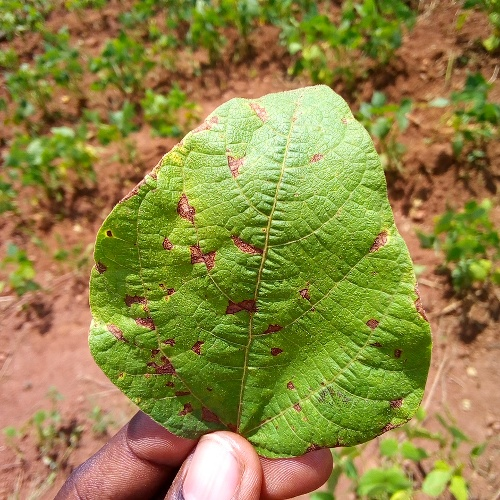

In [4]:
img, cls_num = val_dataset[0]
print(f"Size : {img.size} Class: {val_dataset.classes[cls_num]}") # pillow
display(img)

Создадим загрузчики


In [5]:
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = ImageFolder('test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Создайте сверточную сеть для классификации

При этом:
* Не используйте больше пяти сверточных слоев
* Используйте принцип: при увеличении количества фильтров в два раза, пространственные размеры карты признаков так же уменьшаются в два раза.
* Помните о том, что большой модели может не хватить памяти при изображениях размером 500х500 и batch_size =32







P.s. Нам нужно менять размер изображения в ходе экспериментов, поэтому мы не стали передавать набор трансформаций в конструктор класса датасета. Будем устанавливать это свойство в начале каждого эксперимента.

In [6]:
import torchvision.transforms as T

def get_transforms(side_size):
  # create set of transforms applied to the images
  return T.Compose(
      [
        T.Resize((side_size, side_size)),
        T.ToTensor(),
        T.Normalize(
          mean=[0.5183, 0.4845, 0.6570],
          std=[0.2111, 0.2227, 0.2291]
        )
      ]
    )

Обучите несколько вариантов модели, обрабатывающих входы различного размера. Допустимо использовать вспомогательные функции (validate, train) из первого задания. Для изменения размера изображений рекомендуется использовать механизм трансформаций Pytorch.

**При обучении внутри цикла сохраняйте лучшую модель и размер изображения, при котором удалось достичь максимальной точности на валидационной выборке**

Для сохранения модели в отдельный объект используйте функцию `deepcopy`

In [23]:
import torch.nn as nn
import torch


class BeanCNN(nn.Module):
    def __init__(self, num_conv=4, side_size=500):
        super().__init__()
        layers = []
        in_channels = 3
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(in_channels, in_channels * 2, kernel_size=3))
        in_channels = in_channels * 2
        layers.append(nn.Conv2d(in_channels, in_channels * 2, kernel_size=3))
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        in_channels = in_channels * 2
        layers.append(nn.Conv2d(in_channels, in_channels + 6, kernel_size=3))
        in_channels = in_channels + 6
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        layers.append(nn.Flatten())
        side_size -= 6
        layers.append(nn.Linear(in_channels * (side_size//4) * (side_size//4), 256))
        layers.append(nn.Linear(256, 64))
        layers.append(nn.Linear(64, 3))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

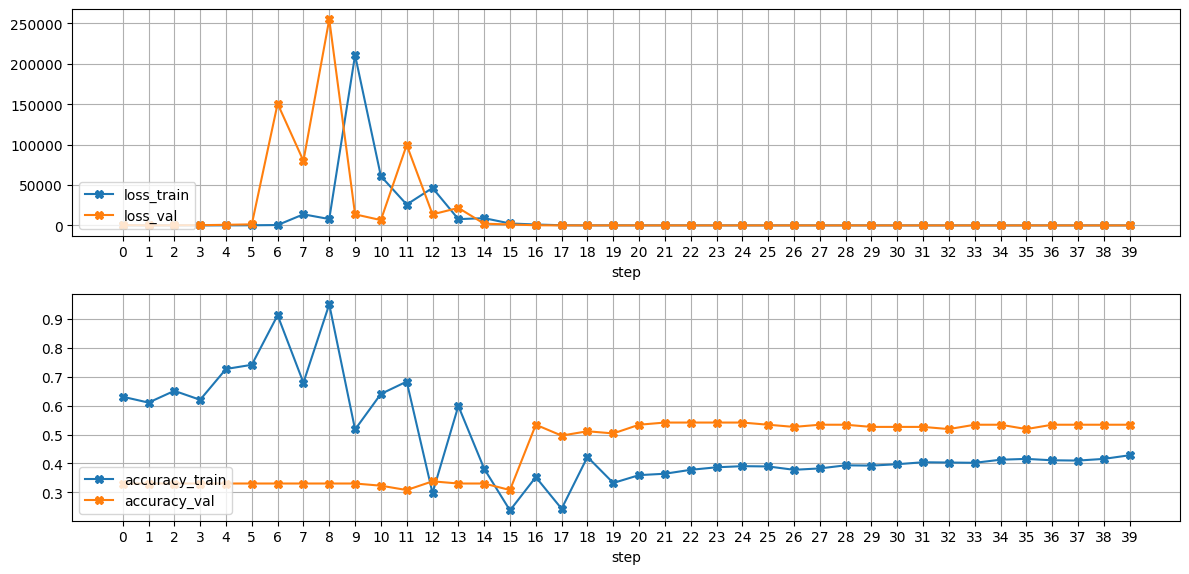

CPU times: user 26min 52s, sys: 2min 44s, total: 29min 36s
Wall time: 29min 13s


In [24]:
%%time
from copy import deepcopy

side_sizes=[500, 256, 128 , 64 ,32]

tacc = []
mas = []
for side_size in side_sizes:
    # Change transform on both datasets
    transform  = get_transforms(side_size)
    train_dataset.transform = transform
    val_dataset.transform = transform
    test_dataset.transform = transform

    model = BeanCNN(side_size=side_size)
    model.train()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_model = model
    prev_acc = 0
    pp = ProgressPlotter()
    for epoch in range(40):
        print('epoch: ', epoch)
        correct, total, ep_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            outputs = outputs.to(device)
            loss = criterion(outputs, labels)
            correct += get_correct_count(outputs,labels)
            loss.backward()
            optimizer.step()
            total += labels.size(0)
            ep_loss += loss.item()
        pp.add_scalar('loss_train', ep_loss / len(train_loader))
        pp.add_scalar('accuracy_train', correct/total)
        accuracy, loss_val = validate(model, val_loader, criterion, device)
        pp.add_scalar('loss_val',loss_val)
        pp.add_scalar('accuracy_val',accuracy)
        pp.display([['loss_train','loss_val'],['accuracy_train','accuracy_val']])
        if accuracy > prev_acc:
          best_model = model
          print(accuracy)
          prev_acc = accuracy
    mas.append(best_model)

Сравните графики значений accuracy для разных размеров входных изображений:

In [25]:
vacc= []
for i in range(len(mas)):
  transform  = get_transforms(side_sizes[i])
  val_dataset.transform = transform
  val_accuracy, _ = calaculate_accuracy(mas[i].eval(), val_loader, criterion)
  vacc.append(val_accuracy)
vacc

[0.6240601503759399,
 0.5639097744360902,
 0.556390977443609,
 0.5939849624060151,
 0.5338345864661654]

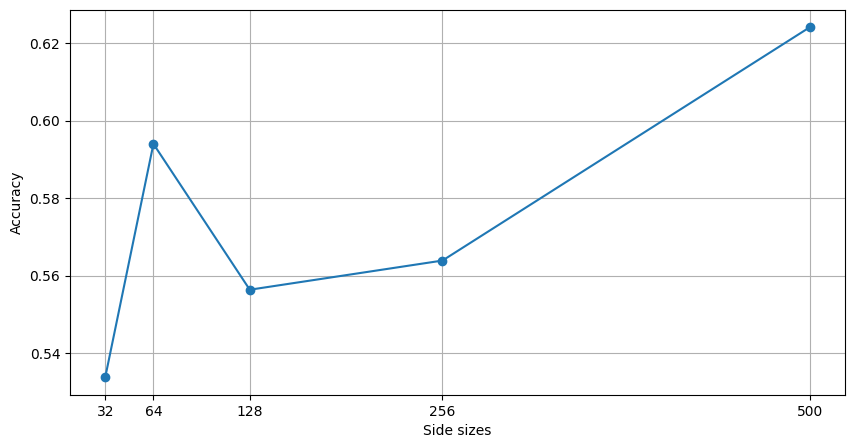

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(side_sizes, vacc, marker='o')
plt.xlabel('Side sizes')
plt.ylabel('Accuracy')
plt.xticks(side_sizes)
plt.grid()
plt.show()

Проверьте результат на тестовом датасете

In [27]:
tacc = []
for i in range(len(mas)):
  transform  = get_transforms(side_sizes[i])
  test_dataset.transform = transform
  test_accuracy, _ = calaculate_accuracy(mas[i].eval(), test_loader, criterion)
  tacc.append(test_accuracy)
tacc

[0.5546875, 0.609375, 0.5078125, 0.5703125, 0.5]

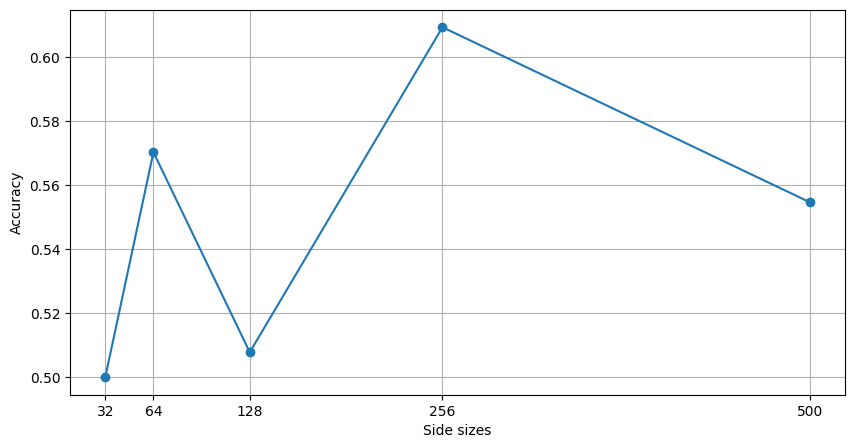

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(side_sizes, tacc, marker='o')
plt.xlabel('Side sizes')
plt.ylabel('Accuracy')
plt.xticks(side_sizes)
plt.grid()
plt.show()

**Вывод:**

Лучшая точность на 256

Точность уменьшается при размере изображения > 256 - это может указывать на то, что архитектура модели не адаптирована к большему количеству информации

Точность уменьшается при размере изображения < 256 - это может указывать на то, что модель теряет важные детали и характеристики, необходимые для правильной классификации. Меньший размер изображения может приводить к потере информации, которая критична для задач распознавания.

Для улучшения модели можно: добавить слои или изменить размеры фильтров, чтобы лучше справляться с большим количеством информации, взять learning rate меньше

## Формат результата

Результатом является показание точности сети при различных размерах входных изображений.

Например:

* Размер изображения 32х32 точность 0.6

* Размер изображения 64х64 точность 0.7

* Размер изображения 500х500 точность 0.57


# Задание 5. Создание сверточной сети для CIFAR10

Создайте сверточную сеть на Pytorch и обучите ее на СIFAR10. Цель получить лучшее качество чем у полносвязанной сети которую мы обучали в 5й лекции.  

* Используйте не более трёх [сверточных](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) и не более двух [полносвязанных](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) слоев, а также один слой [пулинга](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) между ними (слой пулинга и аргумент stride у сверточных слоев помогут избежать большой размерности на входе в линейный слой).
* Функцию активации выберите на свое усмотрение.  
* Не применяйте слои других типов.  
* Используйте код для обучения из лекции №5.

In [29]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = (3,3), padding=1)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 12, kernel_size = (3,3), padding=1)
        self.conv3 = nn.Conv2d(in_channels = 12, out_channels = 24, kernel_size = (3,3), stride=2)
        self.pool = nn.MaxPool2d(kernel_size = (2,2))
        self.flatten = nn.Flatten()
        self.linear0 = nn.Linear(24 * 49, 128)
        self.linear1 = nn.Linear(128, 10)
        self.activation = nn.ReLU()
    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))
        x = self.flatten(self.pool(x))
        x = self.activation(self.linear0(x))
        scores = self.linear1(x)
        return scores

Загрузите CIFAR10:

In [30]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Resize, Normalize, Compose
from torch.utils.data import DataLoader, random_split

torch.manual_seed(42)
transform = Compose(
    [ToTensor(), Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
)

dataset = CIFAR10(root='./CIFAR10', train=True, download=True, transform=transform)
testset = CIFAR10(root='./CIFAR10', train=False, download=True, transform=transform)

batch_size = 256
trainset, valset = random_split(dataset, [45000,5000])
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:13<00:00, 12990929.80it/s]


Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified


Разместите код для обучения в этом блоке.

Используйте GPU. Для этого Вам необходимо в верхней панели выбрать `Среда выполнения > Сменить среду выполнения` и заменить None на GPU.

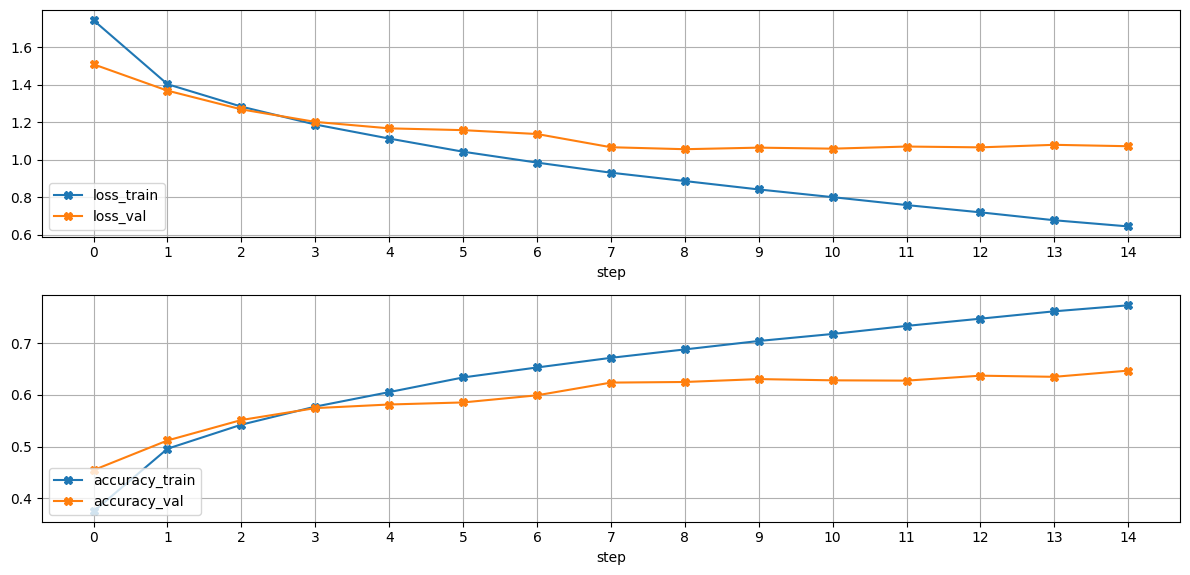

0.647


In [32]:
model = CIFAR10_CNN()
model.train()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
pp = ProgressPlotter()
prev_acc = 0
for epoch in range(15):
    print('epoch: ', epoch)
    correct, total, ep_loss = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)
        correct += get_correct_count(outputs,labels)
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        ep_loss += loss.item()
    pp.add_scalar('loss_train', ep_loss / len(train_loader))
    pp.add_scalar('accuracy_train', correct/total)
    accuracy, loss_val = validate(model, val_loader, criterion, device)
    pp.add_scalar('loss_val',loss_val)
    pp.add_scalar('accuracy_val',accuracy)
    pp.display([['loss_train','loss_val'],['accuracy_train','accuracy_val']])
    if accuracy > prev_acc:
      print(accuracy)
      prev_acc = accuracy
      best_model = model

In [33]:
test_accuracy, _ = calaculate_accuracy(best_model.eval(), test_loader, criterion)
print("test: ", test_accuracy)

test:  0.6486


## Формат результата

Результатом является сверточная сеть обученная на CIFAR10, с точностью не ниже 0.6